. # ДЗ еще не доделано Урок 4. Построение алгоритма дерева решений

In [4]:

!pip install graphviz

In [46]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
import pandas as pd

In [6]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1,
              0, 1, 0, 1, 1], dtype = np.float64)

Неопределенность Джини (Gini impurity): $$G = \sum\limits_k p_k(1 - p_k)^2$$

In [14]:
def gini(x, y, t):
    
    qty_left = len(y[x < t])
    qty_right = len(y[x >= t])
    
    if qty_left == 0 or qty_right == 0:
        return np.inf
    
    qty0_left = np.sum(y[x < t] == 0)
    qty1_right = np.sum(y[x >= t] == 1)
    print(y[x < t])
    print(qty0_left, qty1_right)
    
    p0 = qty0_left/qty_left
    p1 = qty1_right/qty_right
    p = np.array([p0, p1])
    print(p0, p1, p)
    
    g = np.sum(p*(1 - p))
    
    return g

In [15]:
gini(x, y, t=1000)

[0. 0. 1. 0. 0. 1.]
4 3
0.6666666666666666 0.75 [0.66666667 0.75      ]


0.4097222222222222

In [16]:
for t in x:
    print(f'Порог: {t}, Gini: {gini(x, y, t)}')

[1.]
0 4
0.0 0.4444444444444444 [0.         0.44444444]
Порог: 500.0, Gini: 0.24691358024691357
[0. 0. 1.]
2 4
0.6666666666666666 0.5714285714285714 [0.66666667 0.57142857]
Порог: 700.0, Gini: 0.46712018140589573
[0. 0. 0. 1.]
3 4
0.75 0.6666666666666666 [0.75       0.66666667]
Порог: 750.0, Gini: 0.4097222222222222
[0. 1.]
1 4
0.5 0.5 [0.5 0.5]
Порог: 600.0, Gini: 0.5
[0. 0. 1. 0. 0. 1. 1.]
4 2
0.5714285714285714 0.6666666666666666 [0.57142857 0.66666667]
Порог: 1450.0, Gini: 0.46712018140589573
[0. 0. 1. 0. 1.]
3 3
0.6 0.6 [0.6 0.6]
Порог: 800.0, Gini: 0.48
[0. 0. 1. 0. 1. 0. 1. 1.]
4 1
0.5 0.5 [0.5 0.5]
Порог: 1500.0, Gini: 0.5
[0. 0. 1. 0. 1. 0. 1. 1. 1.]
4 0
0.4444444444444444 0.0 [0.44444444 0.        ]
Порог: 2000.0, Gini: 0.24691358024691357
Порог: 450.0, Gini: inf
[0. 0. 1. 0. 0. 1.]
4 3
0.6666666666666666 0.75 [0.66666667 0.75      ]
Порог: 1000.0, Gini: 0.4097222222222222


 ### ООП реализация

In [17]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [18]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction  

In [19]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчёт дисперсии значений (вместо gini)
def dispersion(labels):
    return np.std(labels)


In [20]:
# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Расчет качества для задачи регрессии
def quality_regression(left_labels, right_labels, current_dispersion):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)

In [21]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [58]:
# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Нахождение наилучшего разбиения для задачи регрессии
def find_best_split_regression(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    current_std = dispersion(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_std)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


In [28]:
# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


# Построение дерева регрессии с помощью рекурсивной функции
def build_tree_regression(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split_regression(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree_regression(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_regression(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [29]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# аналог classify_object для регрессии
def predict_object(obj, node):
    
    if isinstance(node, Leaf):
        answer = node.prediction_regression
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [30]:
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# аналог predict_class для регрессии
def predict_value(data, tree):
    
    val = []
    for obj in data:
        prediction = predict_object(obj, tree)
        val.append(prediction)

    return val

## Проверим работоспособность деревьев классификации и  регрессии


In [63]:
# сгенерируем данные

classification_data, classification_labels = datasets.make_classification(n_samples = 200, n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0,  
                                                      n_clusters_per_class=1, random_state=42)


regr_data, regr_labels = datasets.make_regression(n_features = 5, n_informative = 2, 
                                                      noise = 0.1, effective_rank = 4, 
                                                  random_state=2020)

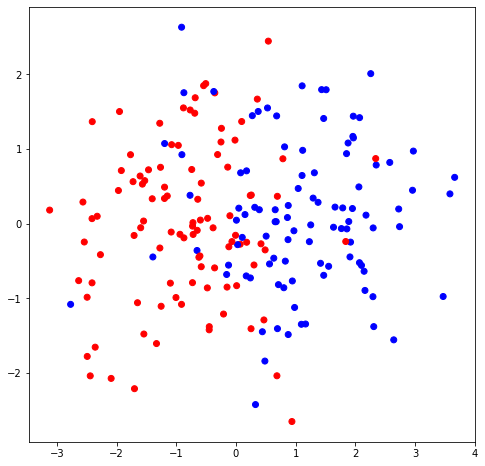

In [64]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

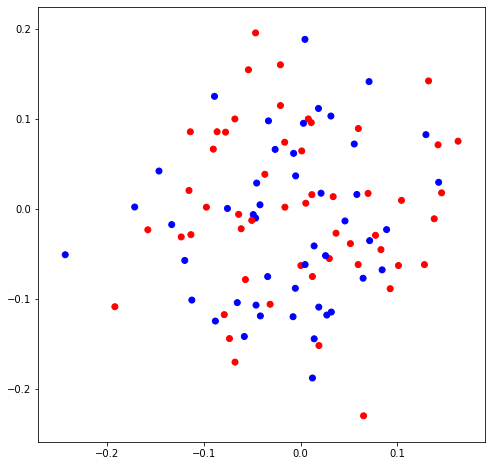

In [65]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], regr_data)), list(map(lambda x: x[1], regr_data)), 
              c=regr_labels, cmap=colors);

In [82]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection


train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

train_data_reg, test_data_reg, train_labels_reg, test_labels_reg = model_selection.train_test_split(regr_data, 
                                                                                     regr_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [97]:
custom_tree = build_tree_classification(train_data, train_labels, max_depth=3)
custom_tree_reg = build_tree_regression(train_data_reg, train_labels_reg, max_depth=5)

In [75]:
custom_tree

In [76]:
custom_tree_reg

In [98]:
y_train_pred = predict_class(train_data, custom_tree)
y_test_pred = predict_class(test_data, custom_tree)


y_train_pred_reg = predict_value(train_data_reg, custom_tree_reg)
y_test_pred_reg = predict_value(test_data_reg, custom_tree_reg)

In [99]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [100]:
print(accuracy_metric(train_labels, y_train_pred))
print(accuracy_metric(test_labels, y_test_pred))

85.0
85.0


In [102]:
print(accuracy_metric(train_labels_reg, y_train_pred_reg))
print(accuracy_metric(test_labels_reg, y_test_pred_reg))

print(rmse(train_labels_reg, y_train_pred_reg))
print(rmse(test_labels_reg, y_test_pred_reg))

print(r2_score(train_labels_reg, y_train_pred_reg))
print(r2_score(test_labels_reg, y_test_pred_reg))

0.0
0.0
7.886804808013436
7.699053891275638
0.04701735262562079
-0.29282755333286525


In [ ]:
# Напечатаем ход нашего дерева
def print_tree_classification(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_classification)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_classification(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_classification(node.false_branch, spacing + "  ")
    
print_tree_classification(custom_tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
y = df['y']
X = df.drop(columns='y')

In [ ]:
sk_tree = DecisionTreeClassifier(random_state=2020).fit(classification_data, classification_labels)

In [ ]:
sk_tree

In [ ]:
export_graphviz(sk_tree, out_file='tree2.dot', 
#                 feature_names = classification_data.columns,
                class_names = ['non-seizure', 'epileptic seizure'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
# import os
# path_to_graphviz = '/home/n-bar/anaconda3/lib/python3.7/site-packages/graphviz' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example) 
# os.environ["PATH"] += os.pathsep + path_to_graphviz

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree2.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

### Домашнее задание. 

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  
2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [ ]:
# Расчёт дисперсии значений (вместо gini)
def dispersion(labels):
    return np.std(labels)


# Расчет качества для задачи регрессии
def quality_regression(left_labels, right_labels, current_dispersion):

    """
    Ваш код здесь
    """
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)


# аналог classify_object для регрессии
def predict_object(obj, node):
    
    """
    Ваш код здесь
    """

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

    
# аналог predict_class для регрессии
def predict_value(data, tree):
    
    """
    Ваш код здесь
    """

    return val
    

# Нахождение наилучшего разбиения для задачи регрессии
def find_best_split_regression(data, labels):
    
    """
    Ваш код здесь
    """

    return best_quality, best_t, best_index


# Построение дерева регрессии с помощью рекурсивной функции
def build_tree_regression(data, labels, tree_depth=1, max_depth=50):

    """
    Ваш код здесь
    """

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)
